In [ ]:
import tensorflow as tf
import os
import random
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
import numpy as np
import glob
# Transfer Learning Inceptionv3
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from keras.layers import *
from keras.models import Sequential
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.models import *
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import sklearn.metrics as metrics
import pandas as pd
import seaborn as sns
from mpl_toolkits.axes_grid1 import ImageGrid


print(tf.__version__)

2.12.0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!ls '/content/drive/My Drive'
%cd '/content/drive/My Drive'

Mounted at /content/drive
 archive.zip	     model_ENB1_2.h5    model_INC3_3.h5    model_RN50.h5
'Colab Notebooks'    model_ENB1_ss.h5   model_INC3_4.h5    model_RN50_ss.h5
 dataminingnew.mp4   model_ENB3_2.h5    model_INC3_ss.h5   veri_mad_birles.mp4
 demo		     model_ENB3_ss.h5   model_RN50_2.h5
 effb3_weights.h5    model_INC3_1.h5    model_RN50_3.h5
 model_ENB1_1.h5     model_INC3_2.h5    model_RN50_4.h5
/content/drive/My Drive


In [ ]:
!unzip '/content/drive/MyDrive/archive.zip' -d '/content/archive'

Görüntülenen çıkış son 5000 satıra kısaltıldı.
  inflating: /content/archive/COVID-19_Radiography_Dataset/Normal/masks/Normal-7921.png  
  inflating: /content/archive/COVID-19_Radiography_Dataset/Normal/masks/Normal-7922.png  
  inflating: /content/archive/COVID-19_Radiography_Dataset/Normal/masks/Normal-7923.png  
  inflating: /content/archive/COVID-19_Radiography_Dataset/Normal/masks/Normal-7924.png  
  inflating: /content/archive/COVID-19_Radiography_Dataset/Normal/masks/Normal-7925.png  
  inflating: /content/archive/COVID-19_Radiography_Dataset/Normal/masks/Normal-7926.png  
  inflating: /content/archive/COVID-19_Radiography_Dataset/Normal/masks/Normal-7927.png  
  inflating: /content/archive/COVID-19_Radiography_Dataset/Normal/masks/Normal-7928.png  
  inflating: /content/archive/COVID-19_Radiography_Dataset/Normal/masks/Normal-7929.png  
  inflating: /content/archive/COVID-19_Radiography_Dataset/Normal/masks/Normal-793.png  
  inflating: /content/archive/COVID-19_Radiography_Dat

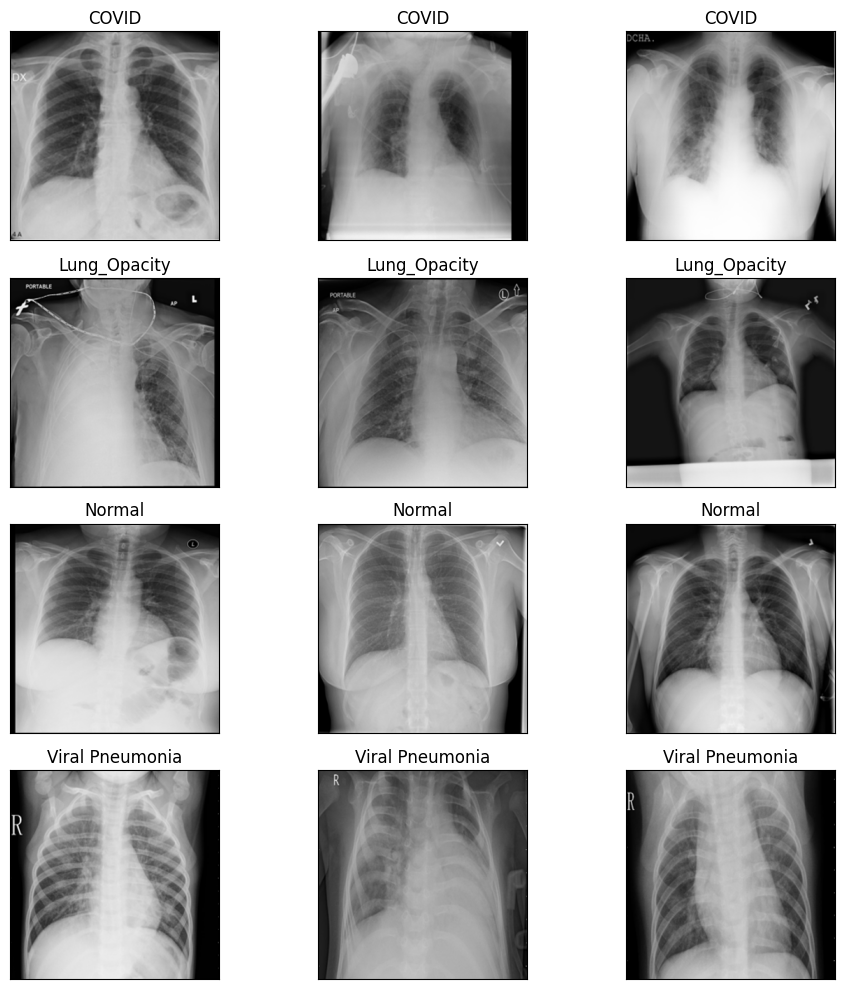

In [ ]:
# Define the path to the directory containing the class folders
path = '/content/archive/COVID-19_Radiography_Dataset'

# Define the names of the class folders
class_names = ['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia']

# Create an empty list to store the selected image filenames
selected_files = []

# Loop through each class folder and randomly select 16 image files from the first file in each folder
for class_name in class_names:
    class_path = os.path.join(path, class_name)
    files = os.listdir(class_path)
    file_path = os.path.join(class_path, files[0])
    image_files = os.listdir(file_path)
    selected_files.extend(random.sample(image_files, 3))

# Create a new figure with 4 rows and 4 columns
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(10,10))

# Loop through the axes and images, and plot each image on the corresponding axis
for i, ax in enumerate(axes.flat):
    # Get the class name and image filename for this axis
    class_name = class_names[i // 3]
    filename = selected_files[i]
    # Open the image using Cv2
    image = cv2.imread(os.path.join(path, class_name, 'images', filename), cv2.IMREAD_COLOR)
    # Plot the image on the axis
    ax.imshow(image)
    # Remove the axis ticks and labels
    ax.set_xticks([])
    ax.set_yticks([])
    # Set the title of the axis to the class name
    ax.set_title(class_name)
plt.tight_layout();
# Display the figure
plt.show()

In [ ]:
imagePaths = []
for dirname, _, filenames in os.walk('/content/archive/COVID-19_Radiography_Dataset'):
    for filename in filenames:
      if (dirname[-5:] != 'masks' and filename[-3:] == 'png'):
          imagePaths.append(os.path.join(dirname, filename))

In [ ]:
imgSize = 224


X = []
Y = []
hmap = {'Viral Pneumonia': 'Pneumonia', 'Normal': 'Normal', 'COVID': 'Covid-19', 'Lung_Opacity': 'Opacity'}

normal_count = 0  # Normal sınıfındaki veri sayısını takip etmek için bir sayaç

for imagePath in tqdm(imagePaths):
    label = imagePath.split(os.path.sep)[-3]
    #print(label)
    image = cv2.imread(imagePath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (imgSize, imgSize))

    X.append(image)
    Y.append(hmap[label])

"""for imagePath in tqdm(imagePaths):
    label = imagePath.split(os.path.sep)[-3]
    #print(label)
    image = cv2.imread(imagePath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (imgSize, imgSize))

    if label == 'Normal' and normal_count < 6000:
        X.append(image)
        Y.append(hmap[label])
        normal_count += 1  # Normal sınıfındaki her veri için sayaç arttırılır
    elif label != 'Normal':
        X.append(image)
        Y.append(hmap[label])"""

"""class_counts = {class_name: 0 for class_name in hmap.values()}  # Sınıfların örnek sayılarını takip etmek için bir sözlük

desired_count = 1345  # Her sınıf için istenen örnek sayısı

for imagePath in tqdm(imagePaths):
    label = imagePath.split(os.path.sep)[-3]
    #print(label)
    image = cv2.imread(imagePath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (imgSize, imgSize))

    if class_counts[hmap[label]] < desired_count:
        X.append(image)
        Y.append(hmap[label])
        class_counts[hmap[label]] += 1

    # Tüm sınıflardan istenen sayıya ulaşıldığında döngüyü sonlandır
    if all(count == desired_count for count in class_counts.values()):
        break

# Veri setini karıştırarak örneklerin sıralamasını rastgele hale getirir
combined_data = list(zip(X, Y))
random.shuffle(combined_data)
X, Y = zip(*combined_data)"""

100%|██████████| 21165/21165 [00:39<00:00, 534.86it/s]


'class_counts = {class_name: 0 for class_name in hmap.values()}  # Sınıfların örnek sayılarını takip etmek için bir sözlük\n\ndesired_count = 1345  # Her sınıf için istenen örnek sayısı\n\nfor imagePath in tqdm(imagePaths):\n    label = imagePath.split(os.path.sep)[-3]\n    #print(label)\n    image = cv2.imread(imagePath)\n    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)\n    image = cv2.resize(image, (imgSize, imgSize))\n\n    if class_counts[hmap[label]] < desired_count:\n        X.append(image)\n        Y.append(hmap[label])\n        class_counts[hmap[label]] += 1\n\n    # Tüm sınıflardan istenen sayıya ulaşıldığında döngüyü sonlandır\n    if all(count == desired_count for count in class_counts.values()):\n        break\n\n# Veri setini karıştırarak örneklerin sıralamasını rastgele hale getirir\ncombined_data = list(zip(X, Y))\nrandom.shuffle(combined_data)\nX, Y = zip(*combined_data)'

In [ ]:
print('Covid-19:',Y.count('Covid-19'))
print('Normal:',Y.count('Normal'))
print('Pneumonia: ',Y.count('Pneumonia'))
print('Lung_Opacity: ',Y.count('Opacity'))

Covid-19: 3616
Normal: 10192
Pneumonia:  1345
Lung_Opacity:  6012


In [ ]:
import random

# Her sınıftan eşit sayıda rastgele örnek seçme
min_samples = 1345

selected_indices = []
for class_label in ['Covid-19', 'Normal', 'Pneumonia', 'Opacity']:
    indices = [i for i, label in enumerate(Y) if label == class_label]
    indices = random.sample(indices, min_samples)
    selected_indices.extend(indices)

# Yeni X ve Y verilerini oluşturma
X = [X[i] for i in selected_indices]
Y = [Y[i] for i in selected_indices]

# Sonuçları yazdırma
print('Covid-19:', Y.count('Covid-19'))
print('Normal:', Y.count('Normal'))
print('Pneumonia:', Y.count('Pneumonia'))
print('Lung_Opacity:', Y.count('Opacity'))

Covid-19: 1345
Normal: 1345
Pneumonia: 1345
Lung_Opacity: 1345


In [ ]:
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

le = LabelEncoder()
Y = le.fit_transform(Y)
print(Y)
#Y = to_categorical(Y)

(trainX, testX, trainY, testY) = train_test_split(X, Y, test_size=0.20, stratify=Y, random_state=42)

[0 0 0 ... 2 2 2]


In [ ]:
le.classes_

array(['Covid-19', 'Normal', 'Opacity', 'Pneumonia'], dtype='<U9')

In [ ]:
from tensorflow.keras.applications import ResNet50

Count_of_class = 4

base_model2 = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3),
    pooling='avg',
)

base_model2.load_weights('/content/drive/MyDrive/model_RN50_ss.h5', by_name=True)

In [ ]:
model_rn50 =  Sequential([
  base_model2
])
model_rn50.summary()

Model: "sequential_117"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
Total params: 23,587,712
Trainable params: 23,534,592
Non-trainable params: 53,120
_________________________________________________________________


In [ ]:
trainX = np.array(trainX)
trainY = np.array(trainY)
testX = np.array(testX)
testY = np.array(testY)


print(testY)

[1 2 3 ... 2 1 1]


In [ ]:
trainX = trainX[0:50]
testX = testX[0:50]

In [ ]:
from tensorflow.keras.applications.efficientnet import preprocess_input

def extract_features_and_labels(images, labels, model):
    features = []
    encoded_labels = []

    for image, label in zip(images, labels):
        # Görüntüyü ön işleme
        image = preprocess_input(image)
        image = np.expand_dims(image, axis=0)

        # Özellik vektörünü elde etme
        features_vector = model.predict(image)

        # Özellik ve etiketleri listelere ekleme
        features.append(features_vector.flatten())
        encoded_labels.append(label)

    return np.array(features), np.array(encoded_labels)

train_features, train_encoded_labels = extract_features_and_labels(trainX, trainY, model_rn50)
test_features, test_encoded_labels = extract_features_and_labels(testX, testY, model_rn50)


Görüntülenen çıkış son 5000 satıra kısaltıldı.
1/1 [==============================] - 0s 26ms/step


## RANDOM FOREST

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

param_grid = {
    'n_estimators' : [50, 100, 150, 200], # number of trees in the random forest #10
    'max_depth' : [10, 20, 30, 40, 50, 60, 70, 80], # maximum number of levels allowed in each decision tree
    'min_samples_split' : [2, 6, 10], # minimum sample number to split a node
    'min_samples_leaf' : [1, 3, 4], # represents the minimum number of samples required to be at a leaf node.
    'bootstrap': [True, False], # when true, each tree in the forest is trained on a random subset of the training data with replacement.
    'criterion' : ['gini', 'entropy']
}

rf = RandomForestClassifier()
rf_grid = RandomizedSearchCV(estimator=rf, param_distributions=param_grid, cv=3, verbose=2, n_jobs=-1)

rf_grid.fit(train_features, train_encoded_labels)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'criterion': ['gini', 'entropy'],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80],
                                        'min_samples_leaf': [1, 3, 4],
                                        'min_samples_split': [2, 6, 10],
                                        'n_estimators': [50, 100, 150, 200]},
                   verbose=2)

In [ ]:
print ('Param grid: ', param_grid, '\n')
# print the best parameters
print ('Best Parameters: ', rf_grid.best_params_, ' \n')

Param grid:  {'n_estimators': [50, 100, 150, 200], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80], 'min_samples_split': [2, 6, 10], 'min_samples_leaf': [1, 3, 4], 'bootstrap': [True, False], 'criterion': ['gini', 'entropy']} 

Best Parameters:  {'n_estimators': 150, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_depth': 70, 'criterion': 'entropy', 'bootstrap': True}  



In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
# Random Forest sınıflandırıcısını oluşturma ve eğitme
randmf = RandomForestClassifier(n_estimators = 100, min_samples_split = 10, min_samples_leaf= 1, max_features = 'sqrt' ,criterion="gini")
randmf.fit(train_features, train_encoded_labels)

# Eğitilen modeli kullanarak test verilerini sınıflandırma
predicted_labels = randmf.predict(test_features)

# Sınıflandırma başarısını raporlama
report = classification_report(test_encoded_labels, predicted_labels,target_names=le.classes_)
print(report)

              precision    recall  f1-score   support

    Covid-19       0.89      0.64      0.75       723
      Normal       0.80      0.91      0.85      2038
     Opacity       0.80      0.75      0.77      1203
   Pneumonia       0.97      0.87      0.92       269

    accuracy                           0.82      4233
   macro avg       0.86      0.79      0.82      4233
weighted avg       0.82      0.82      0.81      4233



In [ ]:
print("\n Cohen's Kappa Score: ",cohen_kappa_score(test_encoded_labels, predicted_labels))


 Cohen's Kappa Score:  0.711945884671731


In [ ]:
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.metrics import classification_report

# # Random Forest sınıflandırıcısını oluşturma ve eğitme
# rf_classifier = RandomForestClassifier()
# rf_classifier.fit(train_features, train_encoded_labels)

# # Eğitilen modeli kullanarak test verilerini sınıflandırma
# predicted_labels = rf_classifier.predict(test_features)

# # Sınıflandırma başarısını raporlama
# classification_report = classification_report(test_encoded_labels, predicted_labels,target_names=le.classes_)
# print(classification_report)


              precision    recall  f1-score   support

    Covid-19       0.68      0.56      0.62       723
      Normal       0.76      0.84      0.80      2038
     Opacity       0.69      0.67      0.68      1203
   Pneumonia       0.73      0.55      0.63       269

    accuracy                           0.73      4233
   macro avg       0.72      0.66      0.68      4233
weighted avg       0.72      0.73      0.72      4233



## XGBOOST


In [ ]:
#TODO: HIPERPARAMETRE OPTIMIZASYONUNA TAM OLARAK BAKILMADI.
import xgboost as xgb
from sklearn.metrics import classification_report
from sklearn.model_selection import RandomizedSearchCV
# XGBoost DMatrix oluşturma
dtrain = xgb.DMatrix(train_features, train_encoded_labels)

"""# Hiperparametre aralıklarını belirleme
params = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.1, 0.01, 0.001],
    'n_estimators': [100, 500, 1000],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

# Hiperparametre optimizasyonu için RandomizedSearchCV kullanma
xgb_classifier = xgb.XGBClassifier(objective='multi:softmax', num_class=Count_of_class)
random_search = RandomizedSearchCV(xgb_classifier, param_distributions=params, n_iter=10, scoring='accuracy', cv=3, verbose=3)
random_search.fit(train_features, train_encoded_labels)

# En iyi hiperparametreleri ve skoru alın
best_params = random_search.best_params_
best_score = random_search.best_score_

print("En iyi hiperparametreler:")
print(best_params)
print("En iyi skor:")
print(best_score)"""


"""
Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV 1/3] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=1000, subsample=1.0;, score=0.785 total time=78.6min
[CV 2/3] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=1000, subsample=1.0;, score=0.787 total time=77.9min
[CV 3/3] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=1000, subsample=1.0;, score=0.786 total time=78.0min
[CV 1/3] END colsample_bytree=0.9, learning_rate=0.001, max_depth=3, n_estimators=1000, subsample=1.0;, score=0.660 total time=46.0min
"""

'\nFitting 3 folds for each of 10 candidates, totalling 30 fits\n[CV 1/3] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=1000, subsample=1.0;, score=0.785 total time=78.6min\n[CV 2/3] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=1000, subsample=1.0;, score=0.787 total time=77.9min\n[CV 3/3] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=1000, subsample=1.0;, score=0.786 total time=78.0min\n[CV 1/3] END colsample_bytree=0.9, learning_rate=0.001, max_depth=3, n_estimators=1000, subsample=1.0;, score=0.660 total time=46.0min\n'

In [ ]:
# En iyi hiperparametrelerle XGBoost modelini oluşturun
xgb_model = xgb.XGBClassifier(objective='multi:softmax', num_class=Count_of_class, colsample_bytree=1.0, max_depth=7,learning_rate=0.1,subsample=0.8,n_estimators=1000)
xgb_model.fit(train_features, train_encoded_labels)

# Test verilerini kullanarak sınıflandırma yapın
y_pred = xgb_model.predict(test_features)

# Sınıflandırma raporunu hesaplayın ve yazdırın
report = classification_report(test_encoded_labels, y_pred,target_names=le.classes_)
print(report)
print("\n Cohen's Kappa Score: ",cohen_kappa_score(test_encoded_labels, y_pred))

              precision    recall  f1-score   support

    Covid-19       0.94      0.86      0.90       723
      Normal       0.88      0.94      0.91      2038
     Opacity       0.88      0.84      0.86      1203
   Pneumonia       0.96      0.95      0.96       269

    accuracy                           0.90      4233
   macro avg       0.92      0.90      0.91      4233
weighted avg       0.90      0.90      0.90      4233


 Cohen's Kappa Score:  0.8404286759301751


## LOGISTIC REGRESSION

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import RandomizedSearchCV


# Hiperparametre aralıklarını belirleme
params = {
    'penalty': ['l1', 'l2'],
    'C': [0.1, 1, 10],
    'solver': ['liblinear', 'saga']
}

# Hiperparametre optimizasyonu için GridSearchCV kullanma
logreg = LogisticRegression(max_iter=1000)
ran_search = RandomizedSearchCV(logreg, param_distributions=params, scoring='accuracy', cv=3, verbose=3)
ran_search.fit(train_features, train_encoded_labels)

# En iyi hiperparametreleri ve skoru alın
best_params = ran_search.best_params_
best_score = ran_search.best_score_

print("En iyi hiperparametreler:")
print(best_params)
print("En iyi skor:")
print(best_score)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV 1/3] END .....C=10, penalty=l1, solver=saga;, score=0.482 total time=   4.6s
[CV 2/3] END .....C=10, penalty=l1, solver=saga;, score=0.482 total time=   0.7s
[CV 3/3] END .....C=10, penalty=l1, solver=saga;, score=0.482 total time=   4.0s
[CV 1/3] END ....C=0.1, penalty=l2, solver=saga;, score=0.482 total time=  11.8s
[CV 2/3] END ....C=0.1, penalty=l2, solver=saga;, score=0.482 total time=  11.3s
[CV 3/3] END ....C=0.1, penalty=l2, solver=saga;, score=0.482 total time=  11.8s
[CV 1/3] END ....C=0.1, penalty=l1, solver=saga;, score=0.482 total time=   0.7s
[CV 2/3] END ....C=0.1, penalty=l1, solver=saga;, score=0.171 total time=   0.8s
[CV 3/3] END ....C=0.1, penalty=l1, solver=saga;, score=0.482 total time=   0.7s
[CV 1/3] END C=0.1, penalty=l2, solver=liblinear;, score=0.482 total time=   2.6s
[CV 2/3] END C=0.1, penalty=l2, solver=liblinear;, score=0.482 total time=   2.6s
[CV 3/3] END C=0.1, penalty=l2, solver=libline

In [ ]:
import numpy as np

# Sınıf sayılarını elde etme
class_counts = np.bincount(Y)

# Sınıf ağırlıklarını hesaplama
total_samples = np.sum(class_counts)
class_weights = total_samples / (len(class_counts) * class_counts)

# Sınıf ağırlıklarını bir sözlük olarak saklama
class_weights_dict = dict(enumerate(class_weights))

In [ ]:
import numpy as np

class_counts = np.bincount(train_encoded_labels)

for class_label, count in enumerate(class_counts):
    print("Class {}: {} örnek".format(class_label, count))

Class 0: 1076 örnek
Class 1: 1076 örnek
Class 2: 1076 örnek
Class 3: 1076 örnek


In [ ]:
class_counts = np.bincount(test_encoded_labels)

for class_label, count in enumerate(class_counts):
    print("Class {}: {} örnek".format(class_label, count))

Class 0: 269 örnek
Class 1: 269 örnek
Class 2: 269 örnek
Class 3: 269 örnek


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import RandomizedSearchCV

# En iyi hiperparametrelerle Logistic Regression modelini oluşturun
logreg_model = LogisticRegression(max_iter=1000, solver='saga',penalty="l1",C=10)
logreg_model.fit(train_features, train_encoded_labels)

# Test verilerini kullanarak sınıflandırma yapın
y_pred = logreg_model.predict(test_features)

# Sınıflandırma raporunu hesaplayın ve yazdırın
report = classification_report(test_encoded_labels, y_pred,target_names=le.classes_)
print(report)
print("\n Cohen's Kappa Score: ",cohen_kappa_score(test_encoded_labels, y_pred))

              precision    recall  f1-score   support

    Covid-19       0.00      0.00      0.00       723
      Normal       0.48      1.00      0.65      2038
     Opacity       0.00      0.00      0.00      1203
   Pneumonia       0.00      0.00      0.00       269

    accuracy                           0.48      4233
   macro avg       0.12      0.25      0.16      4233
weighted avg       0.23      0.48      0.31      4233


 Cohen's Kappa Score:  0.0


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## SVM

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

# Hiperparametre aralıklarını belirleme
params = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

# Hiperparametre optimizasyonu için GridSearchCV kullanma
svm = SVC()
grid_search = GridSearchCV(svm, param_grid=params, scoring='accuracy', cv=3, verbose=3)
grid_search.fit(train_features, train_encoded_labels)

# En iyi hiperparametreleri ve skoru alın
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("En iyi hiperparametreler:")
print(best_params)
print("En iyi skor:")
print(best_score)

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

# En iyi hiperparametrelerle SVM modelini oluşturun
svm_model = SVC(C=10,gamma='scale',kernel="rbf")


svm_model.fit(train_features, train_encoded_labels)

# Test verilerini kullanarak sınıflandırma yapın
y_pred = svm_model.predict(test_features)

# Sınıflandırma raporunu hesaplayın ve yazdırın
report = classification_report(test_encoded_labels, y_pred,target_names=le.classes_)
print(report)
print("\n Cohen's Kappa Score: ",cohen_kappa_score(test_encoded_labels, y_pred))

              precision    recall  f1-score   support

    Covid-19       0.95      0.92      0.94       723
      Normal       0.92      0.94      0.93      2038
     Opacity       0.90      0.88      0.89      1203
   Pneumonia       0.98      0.96      0.97       269

    accuracy                           0.92      4233
   macro avg       0.94      0.93      0.93      4233
weighted avg       0.92      0.92      0.92      4233


 Cohen's Kappa Score:  0.8784730881464436


<function matplotlib.pyplot.show(close=None, block=None)>

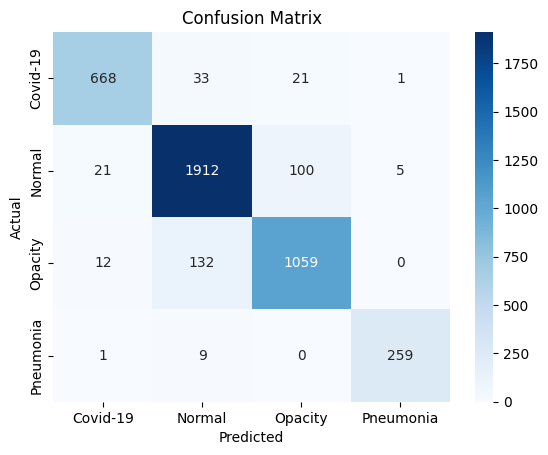

In [ ]:
#Conf Matrix
plt.figure()

ax = plt.subplot()

ax.set_title('Confusion Matrix')
#pred = model.predict(testX)
#pred=np.argmax(pred,axis=1)
# pred = model.predict_classes(X_test)
#Y_TEST = np.argmax(test_encoded_labels, axis =1)
cm = metrics.confusion_matrix(test_encoded_labels,y_pred)
classes=['Covid-19', 'Normal', 'Opacity', 'Pneumonia']
sns.heatmap(cm, annot=True,xticklabels=classes, yticklabels=classes,cmap='Blues',fmt='d')

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show

In [ ]:
%cd '/content/drive/MyDrive/demo'

/content/drive/MyDrive/demo


In [ ]:
import pickle

# Save the model to a file
with open('svm.pkl', 'wb') as f:
    pickle.dump(sv, f)

In [ ]:
with open('/content/drive/MyDrive/demo/svm.pkl', 'rb') as f:
  svm2 = pickle.load(f)

y_pred = svm2.predict(test_features)

# Sınıflandırma raporunu hesaplayın ve yazdırın
report = classification_report(test_encoded_labels, y_pred,target_names=le.classes_)
print(report)
print("\n Cohen's Kappa Score: ",cohen_kappa_score(test_encoded_labels, y_pred))

              precision    recall  f1-score   support

    Covid-19       0.95      0.92      0.94       723
      Normal       0.92      0.94      0.93      2038
     Opacity       0.90      0.88      0.89      1203
   Pneumonia       0.98      0.96      0.97       269

    accuracy                           0.92      4233
   macro avg       0.94      0.93      0.93      4233
weighted avg       0.92      0.92      0.92      4233


 Cohen's Kappa Score:  0.8784730881464436


## KNN

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report


# KNN modelini oluşturun
knn = KNeighborsClassifier()

# GridSearchCV ile hiperparametre optimizasyonu yapın
param_grid = {
    'n_neighbors': [3, 5, 7],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree']
}
grid_search = GridSearchCV(knn, param_grid, cv=3)
grid_search.fit(train_features, train_encoded_labels)

# En iyi parametreleri ve skoru gösterin
print("En iyi parametreler:", grid_search.best_params_)
print("En iyi skor:", grid_search.best_score_)

En iyi parametreler: {'algorithm': 'auto', 'n_neighbors': 7, 'weights': 'distance'}
En iyi skor: 0.8533545948499882


In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report

# En iyi modeli seçin
knn = KNeighborsClassifier(algorithm='auto', n_neighbors = 7, weights='distance')
knn.fit(train_features, train_encoded_labels)

# Test verilerini kullanarak sınıflandırma yapın
y_pred = knn.predict(test_features)

report = classification_report(test_encoded_labels, y_pred,target_names=le.classes_)
print(report)
print("\n Cohen's Kappa Score: ",cohen_kappa_score(test_encoded_labels, y_pred))

              precision    recall  f1-score   support

    Covid-19       0.94      0.77      0.84       723
      Normal       0.81      0.94      0.87      2038
     Opacity       0.85      0.72      0.78      1203
   Pneumonia       0.96      0.91      0.94       269

    accuracy                           0.84      4233
   macro avg       0.89      0.83      0.86      4233
weighted avg       0.85      0.84      0.84      4233


 Cohen's Kappa Score:  0.7555187979997959


## VISUALIZATION

In [ ]:
#Conf Matrix
plt.figure()

ax = plt.subplot()

ax.set_title('Confusion Matrix')
pred = model.predict(testX)
pred=np.argmax(pred,axis=1)
# pred = model.predict_classes(X_test)
Y_TEST = np.argmax(testY, axis =1)
cm = metrics.confusion_matrix(Y_TEST,pred)
classes=['Covid-19', 'Normal', 'Opacity', 'Pneumonia']
sns.heatmap(cm, annot=True,xticklabels=classes, yticklabels=classes,cmap='Blues',fmt='d')

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show

In [ ]:
#Ground Truth

fig = plt.figure(figsize=(10., 10.))
fig.suptitle('Ground Truth', y=0.62)

grid = ImageGrid(fig, 111, # similar to subplot(111)
                 nrows_ncols=(1, 4),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )


n_samples = len(testX)

# Rastgele 5 indeks seçer
random_indices = np.random.choice(n_samples, 5, replace=False)

# Rastgele 5 görüntü ve etiketini yazdırır
for ax,index in zip(grid,random_indices):
    ax.imshow(testX[index])
    #ax.axis('off')
    ax.set_xlabel(le.inverse_transform([np.argmax(testY[index], axis=-1, out=None)])[0])


plt.show()

In [ ]:
#Test
fig2 = plt.figure(figsize=(10., 10.))
fig2.suptitle('Prediction', y=0.62)

grid2 = ImageGrid(fig2, 111, # similar to subplot(111)
                 nrows_ncols=(1, 4),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )

for ax,index in zip(grid2,random_indices):
    ax.imshow(testX[index])
    #ax.axis('off')
    ax.set_xlabel(le.inverse_transform(np.argmax(model.predict(testX[index][None]), axis=1 ))[0])

plt.show()